In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [11]:
import numpy as np
import pandas as pd
import os # 모델 저장할 폴더가 있는지 여부와 폴더 생성

from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.models import Sequential # 모델 객체 생성
from tensorflow.keras.utils import to_categorical # 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.layers import Input, Dense, Dropout # 모델 layer 쌓을 때 필요. 과적합시 필요
from tensorflow.keras.metrics import Recall, Precision # accuracy 외에 정밀도, 재현율 설정
from tensorflow.keras.models import save_model, load_model # 모델 저장, 로드
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint # 로그출력 간소화, epoch다 돌아가기 전에 괜찮으면 끝내는것

from sklearn.preprocessing import LabelEncoder # 라벨인코더
from sklearn.metrics import confusion_matrix # 혼동행렬, 교차표
from sklearn.model_selection import train_test_split # 데이터 분리
from sklearn import datasets # iris 데이터(X,y) 가져오기

import matplotlib.pyplot as plt
import seaborn as sns # iris 데이터(데이터프레임) 가져오기

In [4]:
sns.load_dataset('iris')

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


- 데이터 셋 생성(seaborn) & 전처리
    - X, y(라벨인코딩-원핫인코딩) 분리 → train과 test셋 분리(8:2)
- 모델 구성(입력4, 출력3개, 레이어 5개정도(4→64→128→50→30→3)
- 모델 학습과정 설정
- 모델 학습(EarlyStopping, ModelCheckpoint추가)
- 모델 평가(시각화, 현재모델과 저장된 최고의 모델 평가, 교차표==혼동행렬)
- 모델 예측/저장

# 1. 데이터 셋 생성 & 전처리

In [6]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [8]:
iris.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [9]:
iris['species'].value_counts(normalize=True)

setosa        0.333333
versicolor    0.333333
virginica     0.333333
Name: species, dtype: float64

In [10]:
# 독립변수, 타겟변수 분리

X_iris = iris.iloc[:, :-1]
y_iris = iris.iloc[:, -1]
X_iris.shape, y_iris.shape

((150, 4), (150,))

In [13]:
le = LabelEncoder()
y_iris = le.fit_transform(y_iris)
y_iris

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [15]:
Y_iris = to_categorical(y_iris)
Y_iris.shape

(150, 3)

In [16]:
# 훈련셋, 테스트셋 분리. 층화추출

X_train, X_test, Y_train, Y_test = train_test_split(X_iris, Y_iris, test_size=0.2, stratify=Y_iris)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((120, 4), (30, 4), (120, 3), (30, 3))

In [17]:
np.c_[pd.Series(Y_iris.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

# 2. 모델 구성(입력 4, 출력 3)

In [18]:
model = Sequential()
model.add(Input(4))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=125, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 125)               8125      
                                                                 
 dense_2 (Dense)             (None, 50)                6300      
                                                                 
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dense_4 (Dense)             (None, 3)                 93        
                                                                 
Total params: 16,368
Trainable params: 16,368
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습과정 설정 

# 4. 학습시키기

In [19]:
%%time

# 모델 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 저장경로 설정
model_save_folder = 'model/iris/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'iris-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'

# 콜백객체 생성
checkpoint = ModelCheckpoint(filepath=file,
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)

# 학습
hist = model.fit(X_train, Y_train,
                 epochs=200,
                 validation_split=0.2,
                 verbose=0,
                 callbacks=[checkpoint, earlyStopping])


Epoch 1: val_accuracy improved from -inf to 0.54167, saving model to model/iris\iris-001-loss1.0252-acc0.5417.h5

Epoch 2: val_accuracy improved from 0.54167 to 0.66667, saving model to model/iris\iris-002-loss0.9335-acc0.6667.h5

Epoch 3: val_accuracy improved from 0.66667 to 0.95833, saving model to model/iris\iris-003-loss0.8749-acc0.9583.h5

Epoch 4: val_accuracy did not improve from 0.95833

Epoch 5: val_accuracy did not improve from 0.95833

Epoch 6: val_accuracy did not improve from 0.95833

Epoch 7: val_accuracy did not improve from 0.95833

Epoch 8: val_accuracy did not improve from 0.95833

Epoch 9: val_accuracy did not improve from 0.95833

Epoch 10: val_accuracy did not improve from 0.95833

Epoch 11: val_accuracy did not improve from 0.95833

Epoch 12: val_accuracy did not improve from 0.95833

Epoch 13: val_accuracy did not improve from 0.95833

Epoch 14: val_accuracy did not improve from 0.95833

Epoch 15: val_accuracy did not improve from 0.95833

Epoch 16: val_accurac


Epoch 150: val_accuracy did not improve from 1.00000
CPU times: total: 5.38 s
Wall time: 4.61 s


# 5. 모델 평가

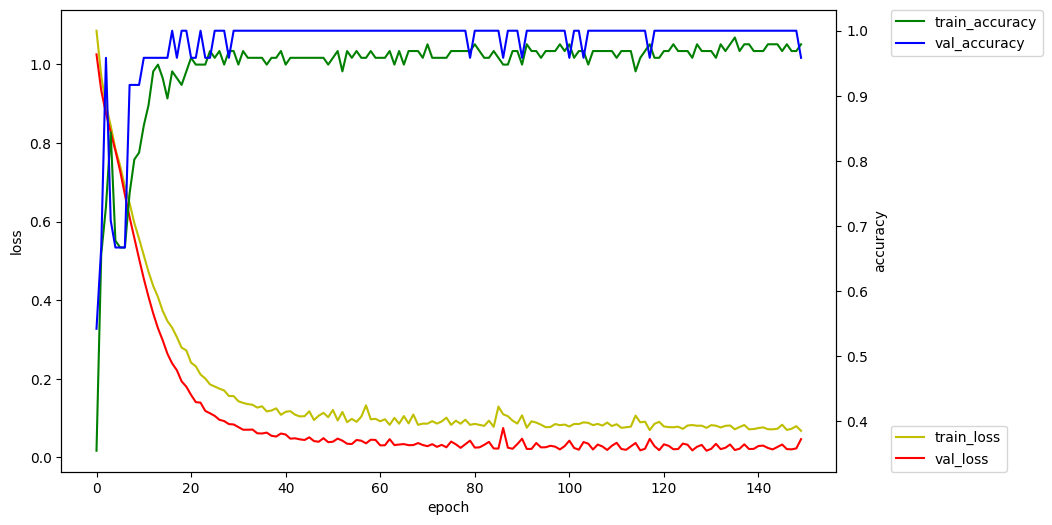

In [20]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [21]:
# 모델 평가

loss_and_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, acc:{loss_and_acc[1]:.4f}')

loss:0.0391, acc:1.0000


In [23]:
model1 = load_model('model/iris.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, acc:{loss_and_acc1[1]:.4f}')

loss:0.2851, acc:1.0000


In [24]:
model.save('model/iris.h5')

In [27]:
real = Y_test.argmax(axis=1)
pred = model.predict(X_test).argmax(axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

1/1 [==============================] - 0s 17ms/step


predict,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,0,10
